In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.en.stop_words import STOP_WORDS as stop_en
from spacy.lang.fr.stop_words import STOP_WORDS as stop_fr
from gensim.models import FastText, Word2Vec

from data import preprocessing
from gensim_embeddings import load_and_create

## Sample length

In [2]:
# Create DataFrame containing English and French aligned samples
data = pd.DataFrame()
data['en']= pd.read_fwf('data/train.lang1', header=None)[0]
data['fr'] = pd.read_fwf('data/train.lang2', header=None)[0]
data.head()

,en,fr
0,so too does the idea that accommodating religi...,L’ idée de concilier les différences religieus...
1,mr president ladies and gentlemen the financia...,"Monsieur le Président , Mesdames et Messieurs ..."
2,reserve should turn into thought - provoking p...,La réticence doit laisser place à une politiqu...
3,it is my profound belief that we can only adva...,Je suis intimement convaincu que nous ne pourr...
4,the european union has territorial waters grea...,Le territoire marin de l' Union européenne est...


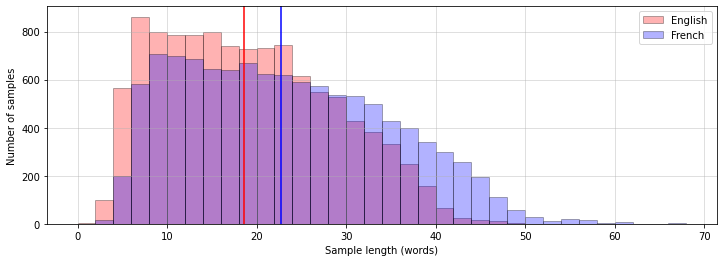

In [5]:
# Figure comparing distribution of sample length (in # of WORDS) for French and English
plt.figure(figsize=(12,4))

len_en = pd.Series([len(x.split()) for x in data['en']])
len_en.hist(bins=np.arange(0, max(len_en)+2, 2), edgecolor='k', color='r', alpha=0.3)

len_fr = pd.Series([len(x.split()) for x in data['fr']])
len_fr.hist(bins=np.arange(0, max(len_fr)+2, 2), edgecolor='k', color='b', alpha=0.3)

plt.grid(alpha=0.5)
plt.legend(['English', 'French'])

plt.axvline(len_en.mean(), color='r')
plt.axvline(len_fr.mean(), color='b')

plt.xlabel('Sample length (words)')
plt.ylabel('Number of samples')

plt.show()

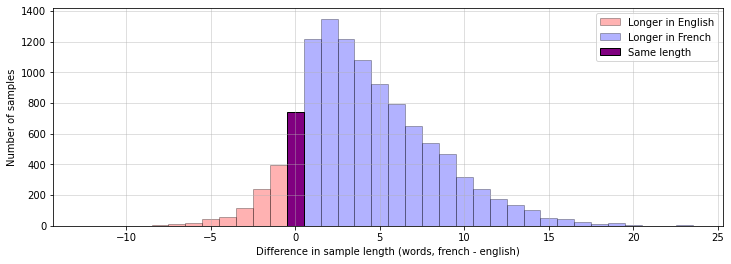

In [6]:
# Figure showing distribution of difference in sample length (in # of WORDS) 
# between aligned English and French samples
plt.figure(figsize=(12,4))
diffs = len_fr-len_en
diffs[diffs<0].hist(bins=np.arange(min(diffs)-0.5,0), edgecolor='k', color='red', alpha=0.3)
diffs[diffs>0].hist(bins=np.arange(0.5,max(diffs)+0.5), edgecolor='k', color='blue', alpha=0.3)
diffs[diffs==0].hist(bins=1, edgecolor='k', color='purple')

plt.grid(alpha=0.5)

plt.xlabel('Difference in sample length (words, french - english)')
plt.ylabel('Number of samples')

plt.legend(['Longer in English', 'Longer in French', 'Same length'])

plt.show()

104.46454545454546
123.5019090909091


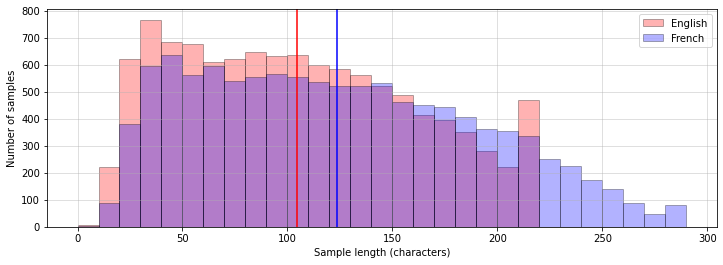

In [14]:
# Figure comparing distribution of sample length (in # of CHARACTERS) for French and English
plt.figure(figsize=(12,4))

len_en = pd.Series([len(x) for x in data['en']])
len_en.hist(bins=np.arange(0, max(len_en)+10, 10), edgecolor='k', color='r', alpha=0.3)

len_fr = pd.Series([len(x) for x in data['fr']])
len_fr.hist(bins=np.arange(0, max(len_fr)+10, 10), edgecolor='k', color='b', alpha=0.3)

plt.grid(alpha=0.5)
plt.legend(['English', 'French'])

plt.axvline(len_en.mean(), color='r')
plt.axvline(len_fr.mean(), color='b')
print(len_en.mean())
print(len_fr.mean())

plt.xlabel('Sample length (characters)')
plt.ylabel('Number of samples')

plt.show()

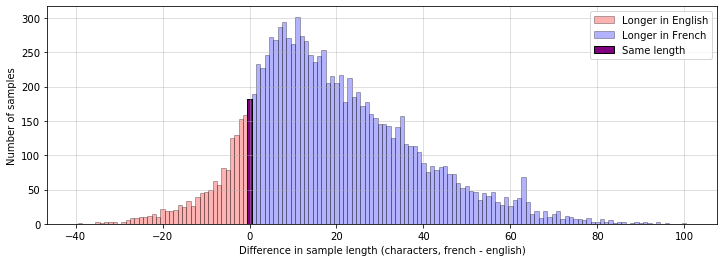

In [327]:
# Figure showing distribution of difference in sample length (in # of CHARACTERS) 
# between aligned English and French samples
plt.figure(figsize=(12,4))
diffs = len_fr-len_en
diffs[diffs<0].hist(bins=np.arange(min(diffs)-0.5,0), edgecolor='k', color='red', alpha=0.3)
diffs[diffs>0].hist(bins=np.arange(0.5,max(diffs)+0.5), edgecolor='k', color='blue', alpha=0.3)
diffs[diffs==0].hist(bins=1, edgecolor='k', color='purple')

plt.grid(alpha=0.5)
plt.legend(['Longer in English', 'Longer in French', 'Same length'])

plt.xlabel('Difference in sample length (characters, french - english)')
plt.ylabel('Number of samples')

plt.show()

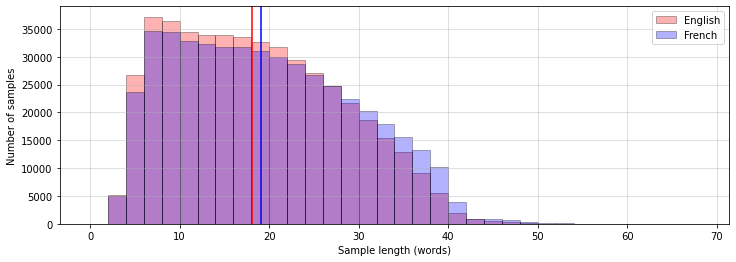

In [27]:
# Figure comparing distribution of sample length (in # of WORDS) for French and English, unaligned
plt.figure(figsize=(12,4))

len_en = pd.Series([len(x.split()) for x in data['en']])
len_en.hist(bins=np.arange(0, max(len_en)+2, 2), edgecolor='k', color='r', alpha=0.3)

len_fr = pd.Series([len(x.split()) for x in data['fr']])
len_fr.hist(bins=np.arange(0, max(len_fr)+2, 2), edgecolor='k', color='b', alpha=0.3)

plt.grid(alpha=0.5)
plt.legend(['English', 'French'])

plt.axvline(len_en.mean(), color='r')
plt.axvline(len_fr.mean(), color='b')

plt.xlabel('Sample length (words)')
plt.ylabel('Number of samples')

plt.savefig('dist_words_unaligned.png')
plt.show()

105.91161814345992
119.43367088607594


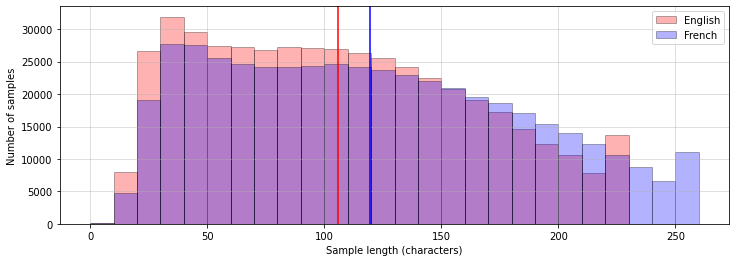

In [28]:
# Figure comparing distribution of sample length (in # of CHARACTERS) for French and English, unaligned
plt.figure(figsize=(12,4))

len_en = pd.Series([len(x) for x in data['en']])
len_en.hist(bins=np.arange(0, max(len_en)+10, 10), edgecolor='k', color='r', alpha=0.3)

len_fr = pd.Series([len(x) for x in data['fr']])
len_fr.hist(bins=np.arange(0, max(len_fr)+10, 10), edgecolor='k', color='b', alpha=0.3)

plt.grid(alpha=0.5)
plt.legend(['English', 'French'])

plt.axvline(len_en.mean(), color='r')
plt.axvline(len_fr.mean(), color='b')

plt.xlabel('Sample length (characters)')
plt.ylabel('Number of samples')

plt.savefig('dist_chars_unaligned.png')
plt.show()

### Vocabulary Properties

In [7]:
# Get vocabulary
vocab_en, _, _ = preprocessing('data/train.lang1')

100%|██████████| 11000/11000 [00:00<00:00, 193777.85it/s]


In [8]:
# Print most common non-stop words
i = 0
for key, value in vocab_en.items():
    if value not in stop_en:
        print(value)
        i += 1
    if i >= 31:
        break

-
european
mr
commission
like
president
parliament
union
time
people
europe
member
states
report
new
countries
council
eu
need
important
policy
years
--
think
know
world
way
work
support
economic
good


In [345]:
# Check for missing values and empty strings
print(data.isna().sum())
print((data['en'] == '').sum())
print((data['fr'] == '').sum())

en    0
fr    0
dtype: int64
0
0


## Word Usage

In [44]:
# Get vocabularies
vocab_en_a, _, _ = preprocessing('data/train.lang1')
vocab_en_u, _, _ = preprocessing('data/unaligned.en')
vocab_fr_a, _, _ = preprocessing('data/train.lang2')
vocab_fr_u, _, _ = preprocessing('data/unaligned.fr')

100%|██████████| 474000/474000 [00:04<00:00, 109780.25it/s]


In [45]:
# Get set of unique words
words_en_a = set(vocab_en_a.values())
words_en_u = set(vocab_en_u.values())
words_fr_a = set(vocab_fr_a.values())
words_fr_u = set(vocab_fr_u.values())

In [51]:
# Calculate how many words in the aligned dataset are not in the unaligned dataset
i = 0
for w in words_en_a:
    if w not in words_en_u:
        i += 1
print(i, '/', len(words_en_a), ':', i/len(words_en_a))

i = 0
for w in words_fr_a:
    if w not in words_fr_u:
        i += 1
print(i, '/', len(words_fr_a), ':', i/len(words_en_a))

756 / 13659 : 0.055348122117285306
1135 / 17349 : 0.0830953949776704


## Embeddings

In [6]:
# model_path = 'embeddings/FastText_CBOW/unaligned_en'
# id2v, v2id, _ = preprocessing('data/unaligned.en')

model_path = 'embeddings/FastText_CBOW/unaligned_fr'
id2v, v2id, _ = preprocessing('data/unaligned.fr')

In [168]:
# Create embedding matrix
emb_mat = load_and_create(model_path, id2v)

In [159]:
# Reduce to 50 dimensions with PCA
# Reduce to 2 dimensions with t-SNE
pca = PCA(50)
tsne = TSNE(2)
emb_mat_50 = pca.fit_transform(emb_mat)
emb_mat_2 = tsne.fit_transform(emb_mat_50)

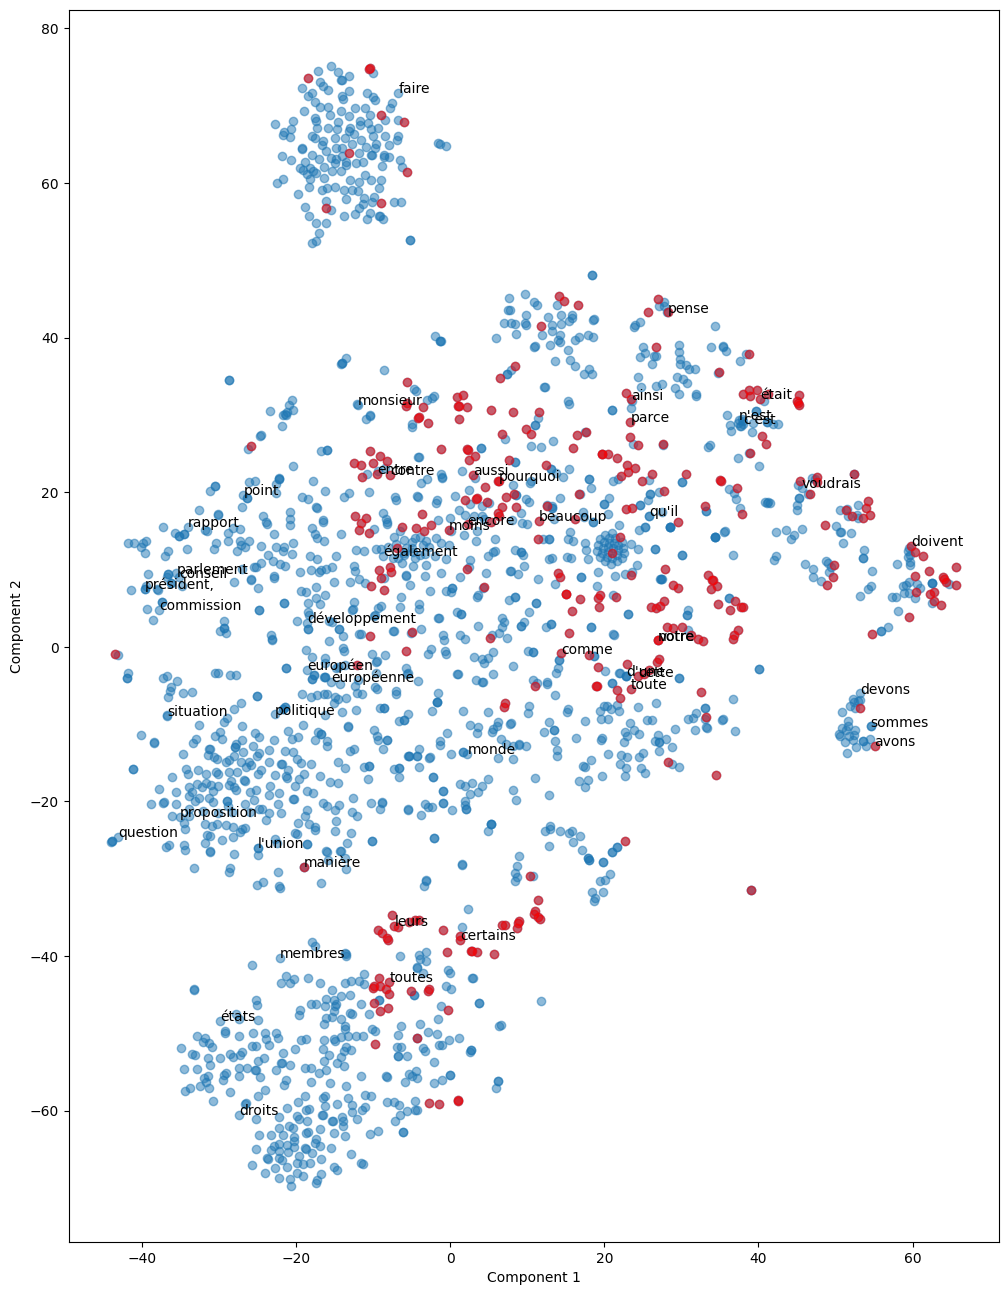

In [153]:
# Plot embeddings
plt.style.use('default')
plt.figure(figsize=(12,16))
plt.scatter(emb_mat_2[:,0], emb_mat_2[:,1], alpha=0.5)

i = 1
j = 0

while j < 50:
    if id2v[i] not in stop_en and not id2v[i].startswith('<') and len(id2v[i]) > 4:
        plt.annotate(id2v[i], (emb_mat_2[i][0], emb_mat_2[i][1]))
        j += 1
    i += 1
    
for idx, word in id2v.items():
    if idx >= emb_mat_2.shape[0]:
        break
    if word in stop_fr:
        plt.scatter(emb_mat_2[idx][0], emb_mat_2[idx][1], color='red', alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.savefig('embeddings.png')
plt.show()

### Similarity

In [169]:
# Get similarities between 2000 random tokens
indices = np.random.randint(0, emb_mat.shape[0], 2000)
sim = cosine_similarity(emb_mat[indices], emb_mat[indices]).flatten()

In [170]:
# Remove self-similarities
sim = sim[np.where(sim <= 0.99999999)]

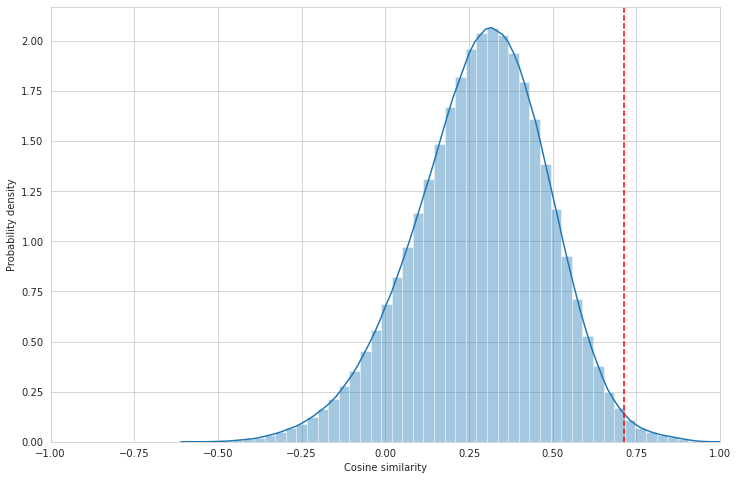

In [171]:
# Plot similarity distribution
sns.set_style('whitegrid')

plt.figure(figsize=(12,8))
sns.distplot(sim, kde=True, norm_hist=False)

plt.xlim(-1,1)
plt.xlabel('Cosine similarity')
plt.ylabel('Probability density')

plt.axvline(np.percentile(sim, 99), color='r', ls='--')

plt.savefig('similarity_fr.png')
plt.show()

In [172]:
np.percentile(sim, 99)

0.7130076391080107

## Language Model

In [3]:
train_loss = [5.9373, 4.9307, 4.7391, 4.6349, 4.5606, 4.5103, 4.4676, 4.4319, 4.4078, 4.3797, 4.3599, 4.3445,
                       4.3241, 4.3132, 4.2983, 4.2848, 4.2775, 4.2634, 4.2583, 4.2466]
val_loss = [5.1233, 4.8106, 4.6828, 4.6028, 4.5471, 4.5057, 4.4728, 4.4482, 4.4261, 4.4080,
                    4.3932, 4.3795, 4.3688, 4.3575, 4.3476, 4.3397, 4.3328, 4.3259, 4.3198, 4.3139]

In [6]:
train_loss_no_ft = [6.3921, 5.8724, 5.7037, 5.5305, 5.3794, 5.2926, 5.2266, 5.1824, 5.1453, 5.1105, 5.0830, 5.0501, 5.0206, 4.9890, 4.9514, 4.9231, 4.8822, 4.8447, 4.8158, 4.7773]
val_loss_no_ft = [5.9579, 5.7770, 5.6277, 5.4425, 5.3294, 5.2595, 5.2073, 5.1652, 5.1321, 5.1029, 5.0734, 5.0425, 5.0121, 4.9781, 4.9467, 4.9130, 4.8783, 4.8449, 4.8130, 4.7839]

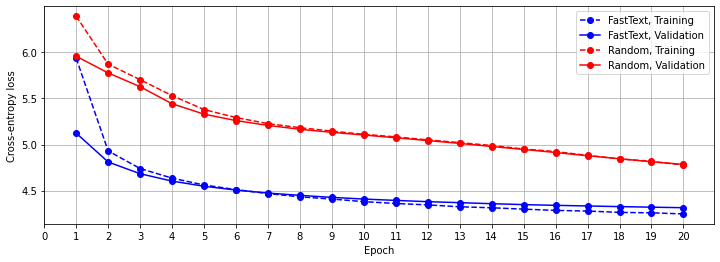

In [10]:
plt.figure(figsize=(12,4))

plt.plot(np.arange(20)+1, train_loss, color='b', marker='o', ls='--')
plt.plot(np.arange(20)+1, val_loss, color='b', marker='o')

plt.plot(np.arange(20)+1, train_loss_no_ft, color='r', marker='o', ls='--')
plt.plot(np.arange(20)+1, val_loss_no_ft, color='r', marker='o')

plt.xticks(np.linspace(0,20,21))

plt.xlabel('Epoch')
plt.ylabel('Cross-entropy loss')

plt.legend(['FastText, Training', 'FastText, Validation', 'Random, Training', 'Random, Validation'])
plt.grid()

plt.savefig('lc_embedding.png')
plt.show()